In [28]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [29]:
## Tool functions.
# Todo: refactor to use deque.
def cycle_list(collection, update_value):
    collection.append(update_value)
    if len(collection) > 10:
        collection.pop(0)

In [30]:
## Signal processing.
# Todo: refactor whole structure to have general separated from methods it is using.
# Todo: refactory to numpy arrays
raw_signal = []
bandpass_signal = []
differentiated_signal = []
squared_signal = []
integrated_signal = []
delay = 0

## Detection.
fiducial_mark = []
spki = 0.0
npki = 0.0
peaki = 0.0
threshold_1 = 1.0
threshold_2 = 0.0
qrs_peak = []
noise_peak = []
rr_interval = 17
rr_current = 0

(0.0, 343.0, 1.1094819306999999, 3.4506354331)

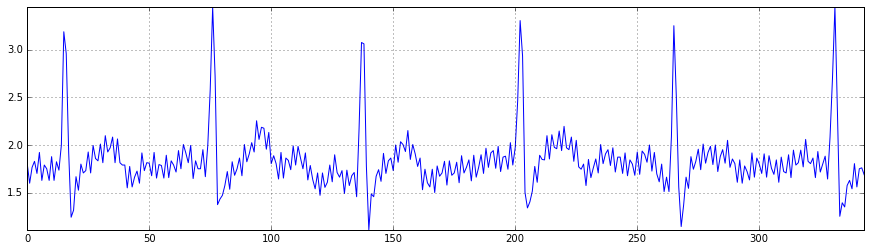

In [31]:
## Load and clean data.
# Todo: refactor to function and call it in __main__
with open("data/pulse4.csv") as f:
    content = f.readlines()

for line in content:
    raw_signal.append(float(line.rstrip().split(';')[1]))
    
plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Original signal")
plt.grid(True)
plt.axis("tight")

(0.0, 343.0, -0.85351142278080483, 1.0254174672234138)

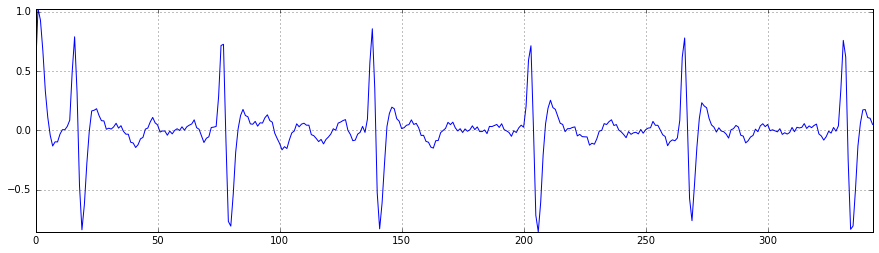

In [32]:
## Signal processing - pass band 5-15 Hz.
# Todo: move filtering parameters to separate section.
# Todo: refactor names like nyq to be more meaningful (e.g. nyquist_freq)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs = 84.0
lowcut = 5.0
highcut = 15.0
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, fs, order=1)

plt.figure(figsize=(15,4))
plt.plot(bandpass_signal, label="Bandpass signal")
plt.grid(True)
plt.axis("tight")

(0.0, 342.0, -0.87681089486291952, 0.52957354699356085)

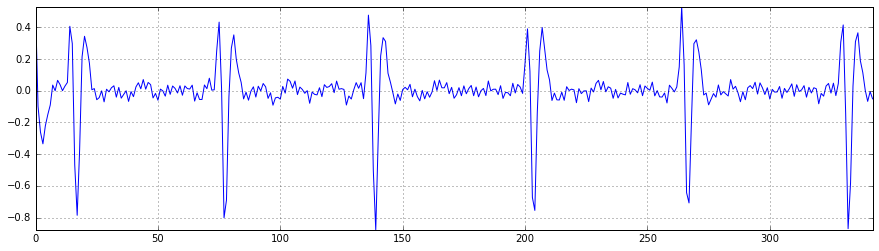

In [33]:
## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)
# Todo: check whether these results should be normalized.
# differentiated_signal = differentiated_signal / max(differentiated_signal)

plt.figure(figsize=(15,4))
plt.plot(differentiated_signal, label="Differentiated signal")
plt.grid(True)
plt.axis("tight")

(0.0, 342.0, 7.1563676895656584e-10, 1.0)

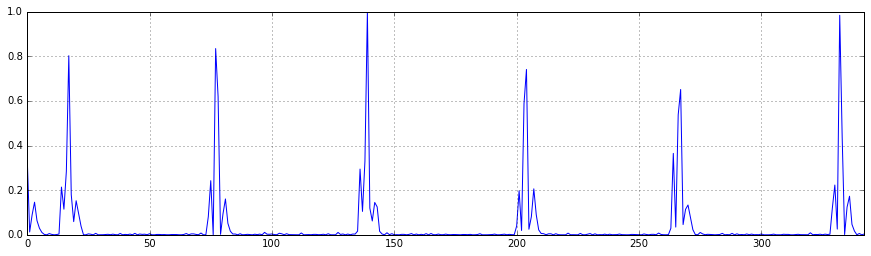

In [34]:
## Squaring - signal is squared point by point.
# Todo: use numpy array vectorized operation to do this squaring.
for sample in differentiated_signal:
    squared_signal.append(sample**2)
# Todo: check whether normalization should be here.
# Todo: normalize using numpy function.
squared_signal = squared_signal / max(squared_signal)

plt.figure(figsize=(15,4))
plt.plot(squared_signal, label="Squared signal")
plt.grid(True)
plt.axis("tight")

(0.0, 353.0, 0.00028892459895648979, 0.18501378300822591)

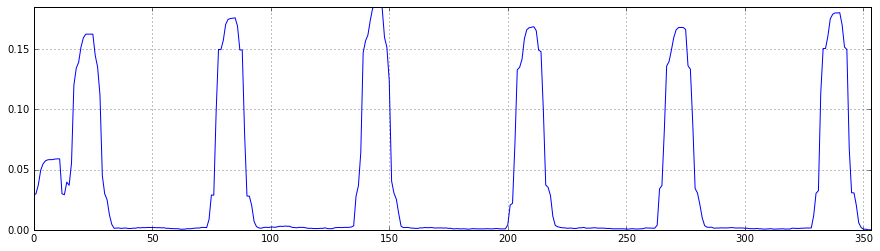

In [35]:
## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
# Todo: check window length
# Todo: dynamic window length based on frequency - first check if freq can be dynamic or can be bigger or smaller
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)
# Todo: check whether result should be normalized.
#integratedSignal = integratedSignal / max(integratedSignal) 

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal")
plt.grid(True)
plt.axis("tight")

(0.0, 353.0, 0.0, 1.0)

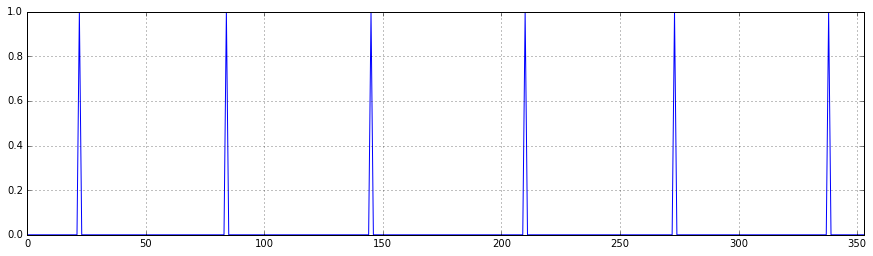

In [36]:
## Fiducial mark - peak detection.
# Todo: investigate usage of find_peaks_cwt
peaks_indices = find_peaks_cwt(integrated_signal, np.arange(10, 15), noise_perc=0.1)
for peak_index in peaks_indices:
    fiducial_mark.append((peak_index, integrated_signal[peak_index]))

fiducial_mark_indication = [0] * len(integrated_signal)
for peak in fiducial_mark:
    fiducial_mark_indication[peak[0]] = 1.0
plt.figure(figsize=(15,4))
plt.plot(fiducial_mark_indication, label='Fiducial signal')
plt.grid(True)
plt.axis('tight')

### Control final values for 'pulse4.csv':

- noise - peak: 0.162209, npki: 0.020276, threshold1: 1.000000
- pulse - peak: 0.175415, spki: 0.021927, threshold1: 0.015207
- pulse - peak: 0.185014, spki: 0.042313, threshold1: 0.020689
- pulse - peak: 0.167958, spki: 0.058018, threshold1: 0.025785
- pulse - peak: 0.167736, spki: 0.071733, threshold1: 0.029712
- pulse - peak: 0.179816, spki: 0.085244, threshold1: 0.033140

noise - peak: 0.162209, npki: 0.020276, threshold1: 1.000000
pulse - peak: 0.175415, spki: 0.021927, threshold1: 0.015207
pulse - peak: 0.185014, spki: 0.042313, threshold1: 0.020689
pulse - peak: 0.167958, spki: 0.058018, threshold1: 0.025785
pulse - peak: 0.167736, spki: 0.071733, threshold1: 0.029712
pulse - peak: 0.179816, spki: 0.085244, threshold1: 0.033140


(0.0, 353.0, 0.0, 1.0)

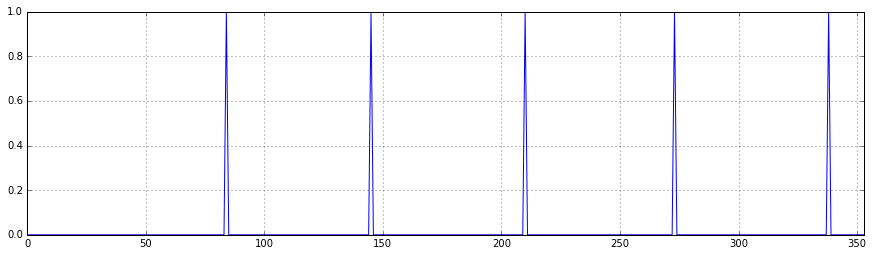

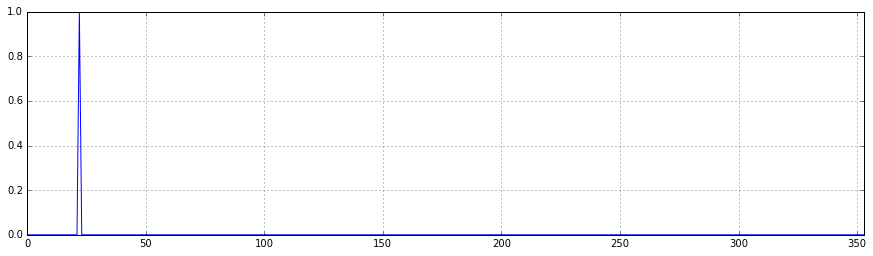

In [37]:
## Thresholding detect peaks.
for peak in fiducial_mark:
    if peak[1] > threshold_1:
        qrs_peak.append(peak[0])
        spki = 0.125 * peak[1] + 0.875 * spki
        print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak[1], spki, threshold_1)
    else:
        noise_peak.append(peak[0])
        npki = 0.125 * peak[1] + 0.875 * npki
        print "noise - peak: %f, npki: %f, threshold1: %f" % (peak[1], npki, threshold_1)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[peak] = 1.0
plt.figure(figsize=(15,4))
plt.plot(qrs_peak_indication, label='QRS peak')
plt.grid(True)
plt.axis('tight')

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = 1.0
plt.figure(figsize=(15,4))
plt.plot(noise_peak_indication, label='Noise peak')
plt.grid(True)
plt.axis('tight')

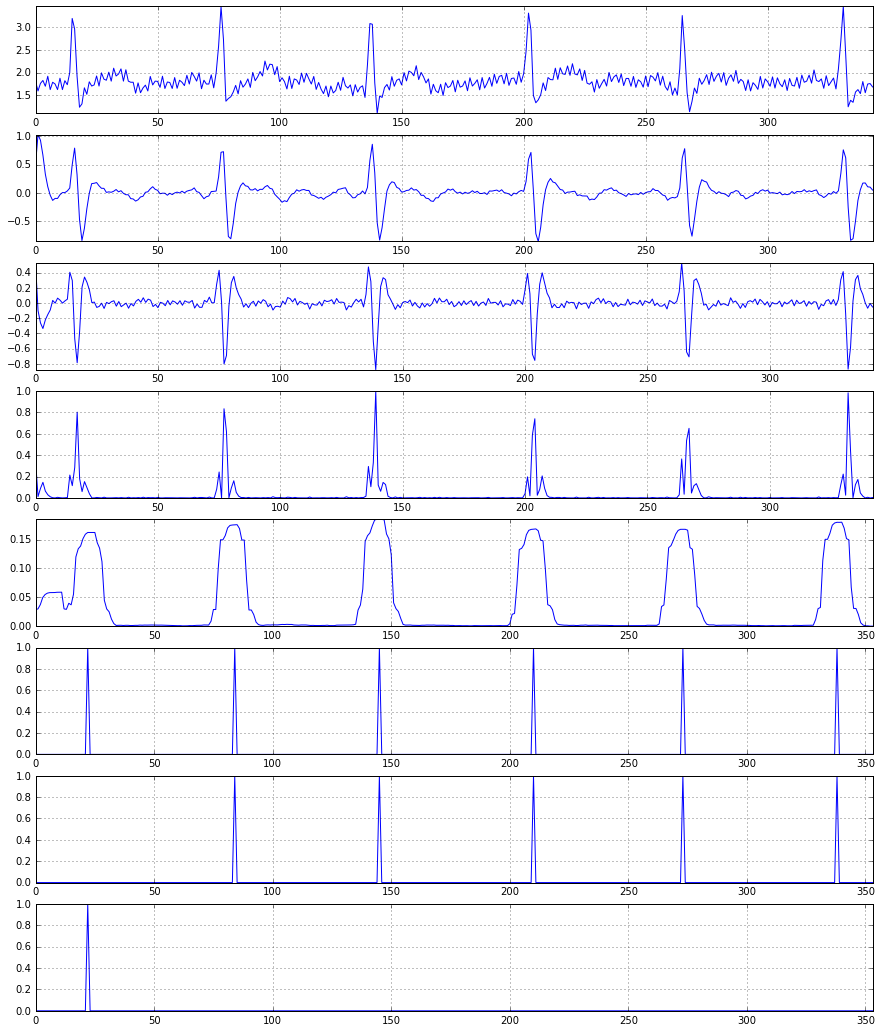

In [38]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak in fiducial_mark:
    fiducial_mark_indication[peak[0]] = 1.0
plt.subplot(816)
plt.plot(fiducial_mark_indication, label='Fiducial signal')
plt.grid(True)
plt.axis('tight')

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[peak] = 1.0
plt.subplot(817)
plt.plot(qrs_peak_indication, label='QRS peak')
plt.grid(True)
plt.axis('tight')

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = 1.0
plt.subplot(818)
plt.plot(noise_peak_indication, label='Noise peak')
plt.grid(True)
plt.axis('tight')
plt.show()  